# Create Weather Data

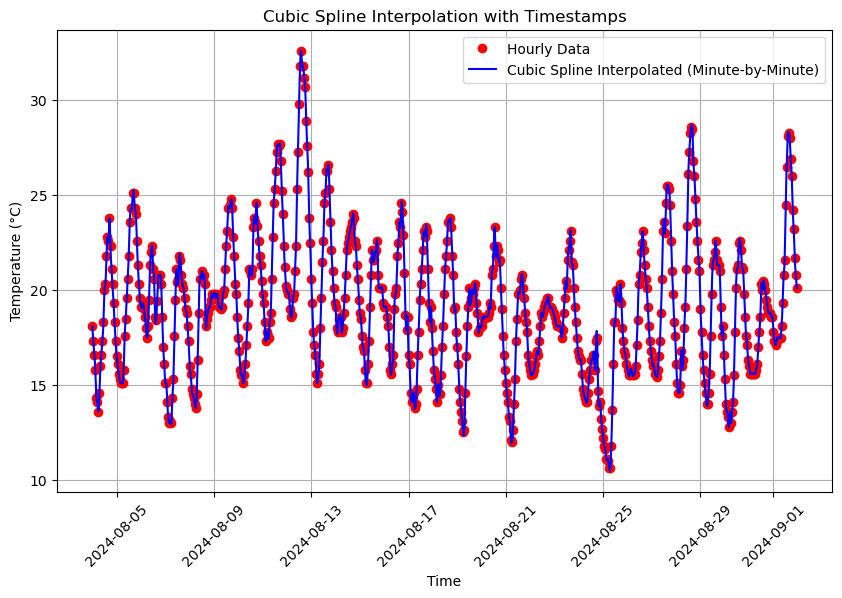

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate

# Read the weather data
weather_data = pd.read_csv('../Utilities/csv/weather_data/london_weather_data.csv')

# Ensure 'datetime' is parsed as a datetime format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Set 'datetime' as the index
weather_data.set_index('datetime', inplace=True)

# Sort the data by datetime (important before resampling)
weather_data = weather_data.sort_index()

# Resample the data to minute-level frequency ('T' for minute)
# This will create gaps in between hour-level data points
weather_data_resampled = weather_data.resample('T').asfreq()

# Use cubic interpolation to fill the gaps
weather_data_resampled[['temp', 'humidity', 'windspeed']] = weather_data_resampled[['temp', 'humidity', 'windspeed']].interpolate(method='cubic')

weather_data.reset_index(inplace=True)
weather_data_resampled.reset_index(inplace=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(weather_data['datetime'], weather_data['temp'], 'o', label='Hourly Data', color='red')
plt.plot(weather_data_resampled['datetime'], weather_data_resampled['temp'], label='Cubic Spline Interpolated (Minute-by-Minute)', color='blue')
plt.title('Cubic Spline Interpolation with Timestamps')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Save the dataset to a CSV file
file_path = "../Utilities/csv/weather_data_minutes.csv"
weather_data_resampled[['datetime', 'temp', 'humidity', 'windspeed']].to_csv(file_path, index=False)


# Generate data

In [13]:
np.random.seed(42)  # For reproducible results

weather_data_resampled = pd.read_csv('../Utilities/csv/weather_data_minutes.csv')
# Generate CPU usage based on the inverse relationship with temperature
cpu_usage = [round(temp + np.random.uniform(-0.5, 0.5), 2) for temp in weather_data_resampled['temp']]

weather_data_resampled['CPU Usage (%)'] = cpu_usage

# Display the first few rows
weather_data_resampled.head()

# Define rush hour periods: 7:30-9:30am and 4:30-6:30pm each day
rush_hour_morning_start = '07:30:00'
rush_hour_morning_end = '09:30:00'
rush_hour_evening_start = '16:30:00'
rush_hour_evening_end = '18:30:00'

# Function to add spikes in CPU usage during rush hours on weekdays and fluctuations elsewhere
def add_data_spikes(df):
    for i, row in df.iterrows():
        time = pd.to_datetime(row['datetime']).time()
        date_format = '%Y-%m-%d %H:%M:%S'
        date_obj = datetime.strptime(str(row['datetime']), date_format)
        fluctuation_precentage = np.random.normal(0, 10)
        # df.at[i, 'Temperature (°C)'] = round(row['Temperature (°C)'] + fluctuation_precentage, 2)
        if (date_obj.weekday() <= 4 and ((rush_hour_morning_start <= time.strftime('%H:%M:%S') <= rush_hour_morning_end) or \
           (rush_hour_evening_start <= time.strftime('%H:%M:%S') <= rush_hour_evening_end))):
            # Add a spike in CPU usage, random boost between 20-40% during rush hours
            df.at[i, 'CPU Usage (%)'] = round(row['CPU Usage (%)'] + np.random.normal(20, 40), 2)
        else:
            df.at[i, 'CPU Usage (%)'] = round(row['CPU Usage (%)'] + fluctuation_precentage, 2)
    return df

# Apply the rush hour spikes to the dataset
data_with_spikes = add_data_spikes(weather_data_resampled)

data_with_spikes_cleaned = data_with_spikes[(data_with_spikes[['CPU Usage (%)']] >= 0).all(axis=1)].copy()

data_with_spikes_cleaned.loc[:, 'temperature_lag_10_mins'] = data_with_spikes_cleaned['temp'].shift(10)
data_with_spikes_cleaned.loc[:, 'temperature_lag_1_hour'] = data_with_spikes_cleaned['temp'].shift(60)

# Drop rows with NaN values in place
data_with_spikes_cleaned.dropna(inplace=True)
print(data_with_spikes_cleaned.head())

# Plot the CPU usage and Temperature together
# fig, ax1 = plt.subplots(figsize=(10, 6))
# ax1.plot(data_with_spikes_cleaned['datetime'], data_with_spikes_cleaned['CPU Usage (%)'], 'g-', label='CPU Usage')
# ax1.set_xlabel('Timestamps')
# ax1.set_ylabel('CPU Usage (%)', color='g')
# ax1.tick_params('y', colors='g')
# ax2 = ax1.twinx()
# ax2.plot(data_with_spikes_cleaned['datetime'], data_with_spikes_cleaned['temp'], 'r-', label='Temperature')
# ax2.set_ylabel('Temperature (°C)')
# ax2.tick_params('y')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.show()

correlation = data_with_spikes_cleaned['CPU Usage (%)'].corr(data_with_spikes_cleaned['temperature_lag_1_hour'])
print(f"Correlation between temperature and CPU Usage: {correlation}")
correlation = data_with_spikes_cleaned['CPU Usage (%)'].corr(data_with_spikes_cleaned['temperature_lag_10_mins'])
print(f"Correlation between temperature and CPU Usage: {correlation}")

temp_col = data_with_spikes_cleaned.pop('CPU Usage (%)')
data_with_spikes_cleaned.insert(1, 'CPU Usage (%)', temp_col)

# Save the dataset to a CSV file
file_path = "../Utilities/csv/data_with_spikes_cleaned.csv"
data_with_spikes_cleaned.to_csv(file_path, index=False)


               datetime       temp   humidity  windspeed  CPU Usage (%)  \
65  2024-08-04 01:05:00  17.235304  57.659503   8.126816          29.96   
66  2024-08-04 01:06:00  17.222458  57.700066   8.114196           1.20   
67  2024-08-04 01:07:00  17.209644  57.740837   8.102269          17.72   
68  2024-08-04 01:08:00  17.196865  57.781810   8.091044          24.82   
69  2024-08-04 01:09:00  17.184120  57.822979   8.080531          20.75   

    temperature_lag_10_mins  temperature_lag_1_hour  
65                17.365390               18.100000  
66                17.352262               18.086846  
67                17.339158               18.073669  
68                17.326079               18.060471  
69                17.313026               18.047252  
Correlation between temperature and CPU Usage: 0.20209457964486482
Correlation between temperature and CPU Usage: 0.22952762186201128


# Generate Replicas

                  datetime  CPU Usage (%)       temp   humidity  windspeed  \
65     2024-08-04 01:05:00          29.96  17.235304  57.659503   8.126816   
66     2024-08-04 01:06:00           1.20  17.222458  57.700066   8.114196   
67     2024-08-04 01:07:00          17.72  17.209644  57.740837   8.102269   
68     2024-08-04 01:08:00          24.82  17.196865  57.781810   8.091044   
69     2024-08-04 01:09:00          20.75  17.184120  57.822979   8.080531   
...                    ...            ...        ...        ...        ...   
41695  2024-09-01 22:55:00          22.95  20.176315  85.401614   7.621666   
41696  2024-09-01 22:56:00          23.24  20.161495  85.433845   7.577883   
41698  2024-09-01 22:58:00          -0.00  20.131200  85.497463   7.489484   
41699  2024-09-01 22:59:00          27.37  20.115716  85.528863   7.444876   
41700  2024-09-01 23:00:00          38.76  20.100000  85.560000   7.400000   

       temperature_lag_10_mins  temperature_lag_1_hour  replica

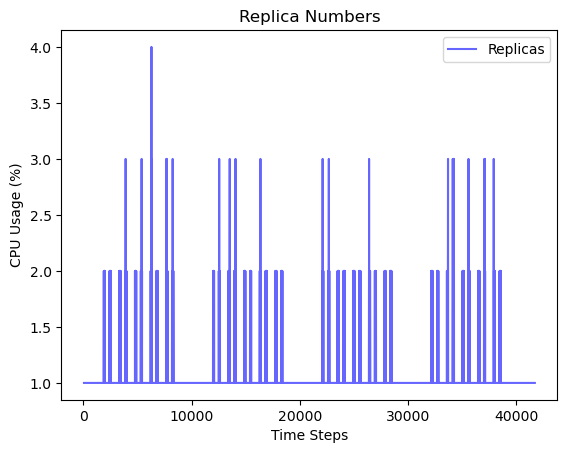

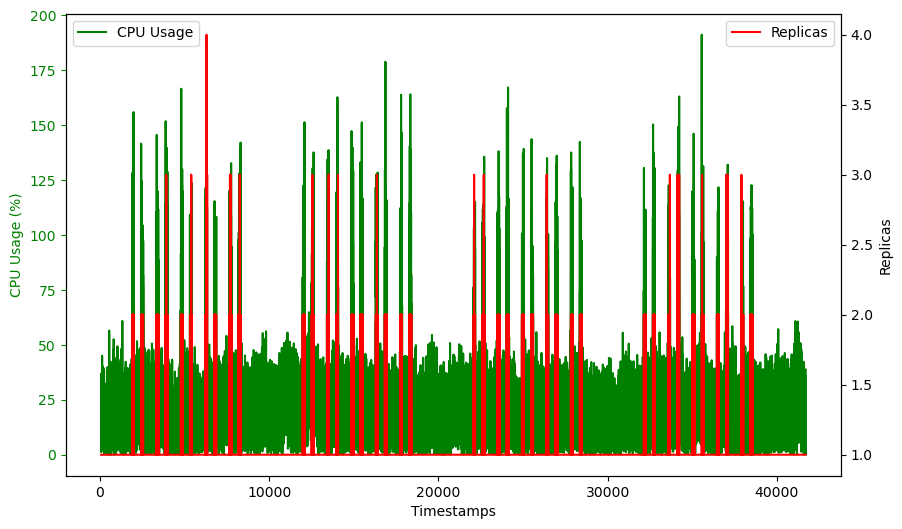

In [14]:
# Variables for tracking cooldown periods and consecutive low CPU usage
scale_up_cooldown = 5  # No scale-up allowed for 5 timesteps after the last scale-up
scale_down_consecutive = 2  # CPU must be below threshold for 2 consecutive timesteps to scale down

# Trackers
time_since_last_scale_up = scale_up_cooldown  # Initialize at cooldown to allow immediate scaling if needed
consecutive_below_threshold = 0  # Track consecutive timesteps below threshold

initial_replicas = 1

# Create a new column 'replicas' based on the CPU usage and SLA threshold (70%)
# We'll increase replicas by 1 each time CPU usage exceeds or equals 70%
threshold = 70
replicas = []
current_replicas = initial_replicas

# Iterate through CPU usage data with the new logic
for cpu_usage in data_with_spikes_cleaned['CPU Usage (%)']:
    # Check if scaling up is allowed
    if cpu_usage >= threshold:
        if time_since_last_scale_up >= scale_up_cooldown:
            current_replicas += 1  # Scale up
            time_since_last_scale_up = 0  # Reset cooldown
        else:
            time_since_last_scale_up += 1  # Increment cooldown timer
        consecutive_below_threshold = 0  # Reset consecutive below counter
    
    # Check for scaling down
    else:
        consecutive_below_threshold += 1
        if consecutive_below_threshold >= scale_down_consecutive and current_replicas > 1:
            current_replicas -= 1  # Scale down
            consecutive_below_threshold = 0  # Reset consecutive counter
        time_since_last_scale_up += 1  # Continue cooldown for scale up

    # Append the current number of replicas to the list
    replicas.append(current_replicas)

# Add the updated replicas to the dataframe
data_with_spikes_cleaned['replicas'] = replicas

# Display the first few rows to check results
print(data_with_spikes_cleaned)

plt.plot(data_with_spikes_cleaned['replicas'], label='Replicas', color='blue', alpha=0.6)
plt.title('Replica Numbers')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data_with_spikes_cleaned['CPU Usage (%)'], 'g-', label='CPU Usage')
ax1.set_xlabel('Timestamps')
ax1.set_ylabel('CPU Usage (%)', color='g')
ax1.tick_params('y', colors='g')
ax2 = ax1.twinx()
ax2.plot(data_with_spikes_cleaned['replicas'], 'r-', label='Replicas')
ax2.set_ylabel('Replicas')
ax2.tick_params('y')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# # Save the dataset to a CSV file
file_path = "../Utilities/csv/cpu_replicas.csv"
data_with_spikes_cleaned[['CPU Usage (%)', 'replicas']].to_csv(file_path, index=False)

# Predict Workload

In [15]:
data = pd.read_csv('../Utilities\csv\data_with_spikes_cleaned.csv')
data.head()
data['datetime'] = pd.to_datetime(data['datetime'])
data.drop('datetime', axis=1, inplace=True)

# features = ['temp', 'humidity', 'windspeed', 'temperature_lag_10_mins', 'temperature_lag_1_hour']
# target = 'CPU Usage (%)'
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# In 10 minute increments
prediction_steps = 10
prediction_lookup = 60
X, y = create_sequences_multi_step(scaled_data, prediction_lookup, prediction_steps)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(prediction_steps))  # Outputting 10 future values

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Checkppoint to ensure the best model is used - decided on best val_loss
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
test_mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")

(31543, 60, 5) (7886, 60, 5) (31543, 10) (7886, 10)
Epoch 1/20
493/493 [==============================] - ETA: 0s - loss: 0.0077
Epoch 1: val_loss improved from inf to 0.00085, saving model to best_model.hdf5
493/493 [==============================] - 128s 235ms/step - loss: 0.0077 - val_loss: 8.5229e-04


c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
493/493 [==============================] - ETA: 0s - loss: 0.0018
Epoch 2: val_loss improved from 0.00085 to 0.00017, saving model to best_model.hdf5
493/493 [==============================] - 110s 223ms/step - loss: 0.0018 - val_loss: 1.6761e-04
Epoch 3/20
493/493 [==============================] - ETA: 0s - loss: 0.0011
Epoch 3: val_loss did not improve from 0.00017
493/493 [==============================] - 107s 217ms/step - loss: 0.0011 - val_loss: 4.8435e-04
Epoch 4/20
493/493 [==============================] - ETA: 0s - loss: 7.3834e-04
Epoch 4: val_loss improved from 0.00017 to 0.00015, saving model to best_model.hdf5
493/493 [==============================] - 105s 213ms/step - loss: 7.3834e-04 - val_loss: 1.5134e-04
Epoch 5/20
493/493 [==============================] - ETA: 0s - loss: 5.3258e-04
Epoch 5: val_loss did not improve from 0.00015
493/493 [==============================] - 106s 214ms/step - loss: 5.3258e-04 - val_loss: 2.1708e-04
Epoch 6/20
493/493 [======

# Forecast prediction

247/247 [==============================] - 16s 50ms/step
[[15.506235  15.5053    15.441701  ... 15.468827  15.473108  15.474456 ]
 [15.5034    15.502381  15.4391165 ... 15.466187  15.469677  15.471867 ]
 [15.502123  15.500838  15.4380045 ... 15.464717  15.467706  15.470543 ]
 ...
 [21.031855  21.02411   20.971344  ... 20.941032  20.993797  20.967562 ]
 [21.021248  21.013767  20.960533  ... 20.930729  20.98337   20.957062 ]
 [21.011581  21.004827  20.950708  ... 20.921635  20.97419   20.947762 ]]
Mean Squared Error for one example: 0.0019164752060135046


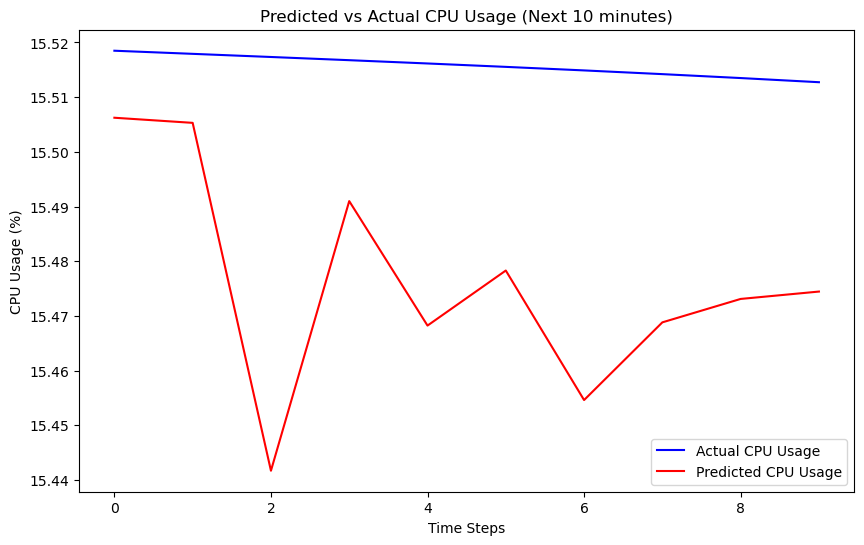

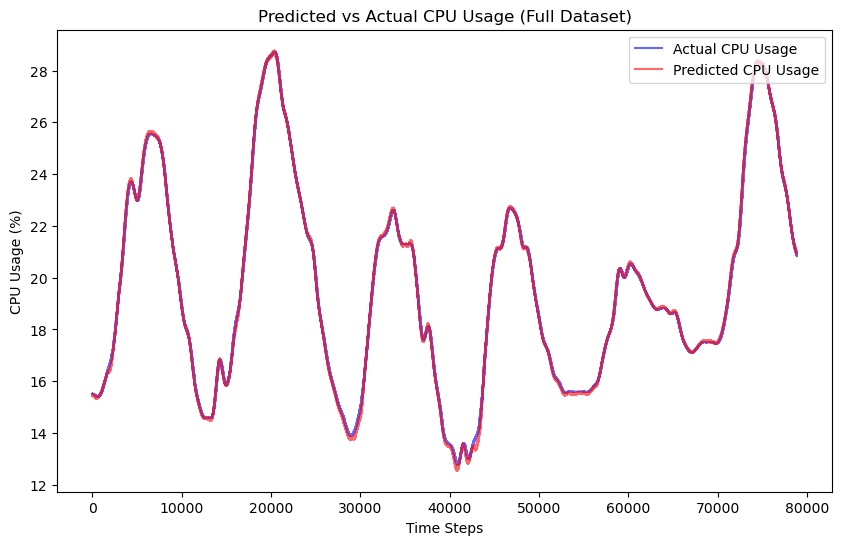

In [16]:
# Make predictions for the next 10 minutes (10 time steps)
predictions = model.predict(X_test)
# Rescale the predicted and actual values (only CPU usage, which is the last feature)
cpu_usage_scaler = MinMaxScaler()
cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

y_test_rescaled = cpu_usage_scaler.inverse_transform(y_test)
predictions_rescaled = cpu_usage_scaler.inverse_transform(predictions)

print(predictions_rescaled)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_rescaled[0], predictions_rescaled[0])
print("Mean Squared Error for one example:", mse)

# Plot the actual vs predicted values (for one example)
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[0], label='Actual CPU Usage', color='blue')
plt.plot(predictions_rescaled[0], label='Predicted CPU Usage', color='red')
plt.title('Predicted vs Actual CPU Usage (Next 10 minutes)')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
# Flatten the entire dataset for actual and predicted CPU usage
y_test_rescaled_flat = y_test_rescaled.flatten()
predictions_rescaled_flat = predictions_rescaled.flatten()
# Plot the entire dataset
plt.plot(y_test_rescaled_flat, label='Actual CPU Usage', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted CPU Usage', color='red', alpha=0.6)
plt.title('Predicted vs Actual CPU Usage (Full Dataset)')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

# Predicting number of replicas

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean Squared Error (MSE): 0.022256610612186947


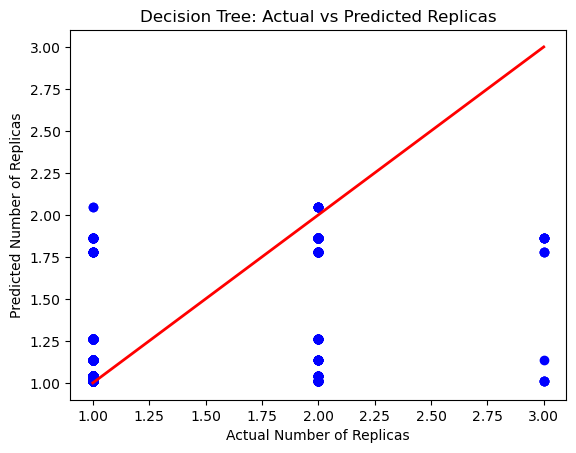

247/247 [==============================] - 12s 47ms/step
Predicted number of replicas for future CPU usage ([[15.506235  15.5053    15.441701  ... 15.468827  15.473108  15.474456 ]
 [15.5034    15.502381  15.4391165 ... 15.466187  15.469677  15.471867 ]
 [15.502123  15.500838  15.4380045 ... 15.464717  15.467706  15.470543 ]
 ...
 [21.031855  21.02411   20.971344  ... 20.941032  20.993797  20.967562 ]
 [21.021248  21.013767  20.960533  ... 20.930729  20.98337   20.957062 ]
 [21.011581  21.004827  20.950708  ... 20.921635  20.97419   20.947762 ]]): [1.00983766 1.00983766 1.00983766 ... 1.00983766 1.00983766 1.00983766]


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')

# Split the data
X = replicas_data[['CPU Usage (%)']]
y = replicas_data['replicas']
X_train_replicas, X_test_replicas, y_train_replicas, y_test_replicas = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_replicas, y_train_replicas)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Predict with the best model
best_model = grid_search.best_estimator_
y_pred_replicas = best_model.predict(X_test_replicas)

# Evaluate the model
mse = mean_squared_error(y_test_replicas, y_pred_replicas)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.scatter(y_test_replicas, y_pred_replicas, color='blue')
plt.plot([y_test_replicas.min(), y_test_replicas.max()], [y_test_replicas.min(), y_test_replicas.max()], color='red', lw=2)
plt.xlabel('Actual Number of Replicas')
plt.ylabel('Predicted Number of Replicas')
plt.title('Decision Tree: Actual vs Predicted Replicas')
plt.show()

# Predict using LSTM output
predictions = model.predict(X_test)
# cpu_usage_scaler = MinMaxScaler()
# cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_rescaled = cpu_usage_scaler.inverse_transform(predictions)

future_replicas = best_model.predict(predictions_rescaled.reshape(-1, 1))
print(f'Predicted number of replicas for future CPU usage ({predictions_rescaled}): {future_replicas}')

# Detect Burst

In [61]:
import time
from kubernetes import client, config
import requests
import json
from datetime import datetime, timedelta

def get_time_range():
    end_time = int(time.time())  # Current timestamp in seconds
    start_time = end_time - (3 * 3600) # Hours in seconds
    return start_time, end_time

# Prometheus server URL (adjust according to your setup)
PROMETHEUS_URL = "http://localhost:9090"

def query_prometheus_range(query, start_time, end_time, step):
    params = {
        'query': query,
        'start': start_time,
        'end': end_time,
        'step': step  # Interval between points (e.g., 60s = 1 minute intervals)
    }
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query_range", params=params)
    return response.json()

# Function to get CPU usage for a pod over the past hour
def get_pod_cpu_usage_range(pod_name, start_time, end_time):
    # Prometheus query to get CPU usage over the last hour (rate over 1 minute)
    query = f'(sum(rate(container_cpu_usage_seconds_total{{pod=~"{pod_name}-.*"}}[1m])) by (pod)) / (sum(kube_pod_container_resource_limits{{pod=~"{pod_name}-.*", resource="cpu"}}) by (pod)) * 100'

    # Query Prometheus with a 60-second step interval
    result = query_prometheus_range(query, start_time, end_time, step="60")

    return result

# Function to convert the Prometheus result to a pandas DataFrame
def prometheus_to_dataframe(prometheus_result):
    if not prometheus_result or 'data' not in prometheus_result:
        return pd.DataFrame()  # Return an empty DataFrame if there's no data

    # Extract the 'values' from the first result (assuming only one pod)
    values = prometheus_result['data']['result'][0]['values']

    # Create a DataFrame from the values
    df = pd.DataFrame(values, columns=['timestamp', 'value'])

    # Convert UNIX timestamp to human-readable datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # Convert the value column to float
    df['value'] = df['value'].astype(float)

    return df

# Get weather data
def get_weather_data(start_time, end_time):
    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

def get_dataset():
    start_time, end_time = get_time_range()
    weather_data_1h = get_weather_data(start_time, end_time)
    pod_cpu_data = get_pod_cpu_usage_range("microsvc", start_time, end_time)

    # Convert the data to a pandas DataFrame
    cluster_data_1h = prometheus_to_dataframe(pod_cpu_data)

    cluster_data_1h['timestamp'] = pd.to_datetime(cluster_data_1h['timestamp']).dt.floor('T')
    weather_data_1h['time'] = pd.to_datetime(weather_data_1h['time']).dt.floor('T')
    full_1h_data = pd.merge(cluster_data_1h, weather_data_1h, left_on='timestamp', right_on='time')
    full_1h_data = full_1h_data.drop('time', axis=1)
    full_1h_data = full_1h_data.drop('timestamp', axis=1)
    full_1h_data.loc[:, 'temperature_lag_10_mins'] = full_1h_data['temperature'].shift(10)
    full_1h_data.loc[:, 'temperature_lag_1_hour'] = full_1h_data['temperature'].shift(60)
    full_1h_data.dropna(inplace=True)
    return full_1h_data

def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# Load kube config
config.load_kube_config()
# If running inside the cluster, use:
# config.load_incluster_config()

def scale_out(additional_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = current_replicas + additional_replicas
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled out to {new_replicas} replicas.")
    return new_replicas

def scale_in(remove_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = max(current_replicas - remove_replicas, 1)
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled in to {new_replicas} replicas.")
    return new_replicas

def detect_burst(monitoring_interval, window_size, resource_prediction_model, replica_prediction_model, replicas):
    is_burst = False
    replicas_before_burst = 0
    past_predictions = np.array([])
    cpu_usage_scaler = MinMaxScaler()
    # while True:
    x = 0
    while x < 5:
        x += 1
        time.sleep(monitoring_interval)
        full_3h_data = get_dataset()
        scaled_data = scaler.fit_transform(full_3h_data)
        # In 10 minute increments
        prediction_steps = 10
        prediction_lookup = 60
        predict_data, predict_labels = create_sequences_multi_step(scaled_data, prediction_lookup, prediction_steps)
        cpu_predictions = resource_prediction_model.predict(predict_data)
        cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
        predictions_rescaled = cpu_usage_scaler.inverse_transform(cpu_predictions)
        n_predicted = replica_prediction_model.predict(predictions_rescaled.reshape(-1, 1))
        past_predictions = np.append(past_predictions, n_predicted)
        sd_max = 0
        n_max = 0
        for i in range(1, window_size + 1):
            sigma_i = np.std(past_predictions)

            if sigma_i > sd_max:
                sd_max = sigma_i
                n_max = max(past_predictions.flatten())

        if sd_max >= 2 and not is_burst:
            # Detected burst, increase replicas to n_max
            replicas_during_burst = n_max
            is_burst = True
            replicas_before_burst = n_predicted  # Store current predicted replicas before burst
        elif sd_max >= 2 and is_burst:
            # Continuation of the burst
            replicas_during_burst = n_max
        elif sd_max < 2 and is_burst:
            if replicas_before_burst > n_predicted:
                # Burst ending, scale back to predicted replicas
                replicas_during_burst = n_predicted
                is_burst = False
                replicas_before_burst = 0
            else:
                # Keep scaling at n_max
                replicas_during_burst = n_max
        else:
            # Normal condition, set replicas to predicted
            replicas_during_burst = n_predicted[0]

        current_replica_count = int(round(replicas))
        replicas_during_burst = int(round(replicas_during_burst))

        if current_replica_count < replicas_during_burst:
            additional_replicas = int(round(replicas_during_burst - current_replica_count))
            replicas = scale_out(additional_replicas, 'microsvc', namespace='default')
        elif current_replica_count > replicas_during_burst:
            replica_difference = int(round(current_replica_count - replicas_during_burst))
            replicas = scale_in(replica_difference, 'microsvc', namespace='default')
        # Log the updated replica count
        print(f"Updated replica count: {replicas}")


api = client.AppsV1Api()
deployment = api.read_namespaced_deployment('microsvc', namespace='default')
replicas = deployment.spec.replicas
print(f"Original replica count: {replicas}")
detect_burst(60, 10, model, best_model, replicas)

Original replica count: 1
2/2 [==============================] - 0s 43ms/step
Updated replica count: 1


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


2/2 [==============================] - 0s 54ms/step
Updated replica count: 1


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


2/2 [==============================] - 0s 37ms/step
Updated replica count: 1


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


2/2 [==============================] - 0s 92ms/step
Updated replica count: 1


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


2/2 [==============================] - 0s 39ms/step
Updated replica count: 1


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


# Create HPA System

In [ ]:
# import joblib

# joblib.dump(model, 'cpu_usage_predictor.pkl')
# joblib.dump(best_model, 'replicas_predictor.pkl')
